# Figure 6A

# Import packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
import matplotlib.colors
plt.rcParams.update({'font.size': 20})

# Definitions

Function to compute the Hill coefficient of a curve z(x) fitting the curve with an Hill function

In [2]:
def model_piu(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def model_meno(x, a, b,c):
    return - c*x**a/(x**a+b**a) 

def Hill_fit_piu(z,x,model, bo):
    y= z-min(z)
    yR= y/max(y)
    popt, _ = curve_fit(model, x, yR, bounds=bo)
    a,b,c = popt  
    return [round(a,8), round(b,8), round(c,8)]

def Hill_fit_meno(z,x,model, bo):
    y= z-min(z)
    yR= y/max(y) - 1
    popt, _ = curve_fit(model, x, yR, bounds=bo)
    a,b,c = popt
    return [round(a,8), round(b,8), round(c,8)]

Function to plot the heatmap

In [3]:
# My Heatmap
def myHeatmap(data, Min, Max, axs, label): 
    sb.heatmap(data,cmap=cmap,fmt=".4f",vmin=Min, vmax=Max, cbar=True, ax=axs, xticklabels=False, yticklabels=10, cbar_kws={'label': label,"orientation": "horizontal"}, center=0)
    
# Find min and max values of the matrix
def min_array(data):
    min_temp = np.zeros(len(data))
    for i in range(len(data)): 
        min_temp[i]= min(data[i,:])
        
    min_final= min(min_temp)
    return min_final

def max_array(data):
    max_temp = np.zeros(len(data))
    for i in range(len(data)): 
        max_temp[i]= max(data[i,:])
        
    max_final= max(max_temp)
    return max_final

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

The evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Solve the equation 
sol = solve(expr_S1S2, T)[1]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5, S2_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v),(S2,S2_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T):

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

# Results 

## Figure 6A

In [34]:
# Definition of the parameters 
Kb_temp= np.linspace(0.01,1,50)
Kd_temp=  np.linspace(1,2000,50)
Ke_temp=  np.linspace(1,2000,50)
Ks_temp=  np.linspace(1,2000,50)
Krg_temp= np.linspace(1,2000,50)
K2_temp= np.linspace(0.01,1,50)
K1_temp= np.linspace(0.01,1,50)
Vrg_temp= np.linspace(0.01,1,50)
Vs_temp= np.linspace(0.01,1,50)
Kerk_temp= np.linspace(0.01,1,50)

# Fix S2 = 0.2 and vary S1 from 0 to 0.8 
S_fix = 0.2
S_max = 1-S_fix
LogS_max = np.log10(S_max)

E_temp = np.logspace(-6,5,50) 
S2_temp= np.logspace(-2,LogS_max,50)

n_Stemp = 50

Erk as a function of S1, S2 for different values of Kb

In [10]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Kb_S1_fit = np.ones(len(Kb_temp))

for kk in range(len(Kb_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], S2_v= S_fix, Kb_v = Kb_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve
    n_Kb_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [11]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Kb_S2_fit = np.ones(len(Kb_temp))

for kk in range(len(Kb_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i], S1_v=S_fix, Kb_v = Kb_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve 
    n_Kb_S2_fit[kk] = Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1, S2 for different values of Kd

In [12]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Kd_S1_fit = np.ones(len(Kd_temp))

for kk in range(len(Kd_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], S2_v=S_fix, Kd_v = Kd_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve 
    n_Kd_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [13]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Kd_S2_fit = np.ones(len(Kd_temp))

for kk in range(len(Kd_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v= S_fix, Kd_v = Kd_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_Kd_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1, S2 for different values of Ke

In [14]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Ke_S1_fit = np.ones(len(Ke_temp))

for kk in range(len(Ke_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i],S2_v=S_fix, Ke_v = Ke_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve 
    n_Ke_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [15]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Ke_S2_fit = np.ones(len(Ke_temp))

for kk in range(len(Ke_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i], S1_v=S_fix, Ke_v = Ke_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve 
    n_Ke_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1, S2 for different values of K1

In [16]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_K1_S1_fit = np.ones(len(K1_temp))
par = [0.4, 3, 1]

for kk in range(len(K1_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i],S2_v=S_fix, K1_v = K1_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve
    n_K1_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,100,100)))[0] # fit

In [17]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_K1_S2_fit = np.ones(len(K1_temp))

for kk in range(len(K1_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v=S_fix,  K1_v = K1_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_K1_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1, S2 for different values of K2

In [18]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_K2_S1_fit = np.ones(len(K2_temp))

for kk in range(len(K2_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], S2_v=S_fix, K2_v = K2_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve 
    n_K2_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [19]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_K2_S2_fit = np.ones(len(K2_temp))

for kk in range(len(K2_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i], S1_v=S_fix, K2_v = K2_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_K2_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1,S2 for different values of Vs

In [20]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Vs_S1_fit = np.ones(len(Vs_temp))

for kk in range(len(Vs_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], S2_v=S_fix, Vs_v = Vs_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve
    n_Vs_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [21]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Vs_S2_fit = np.ones(len(Vs_temp))

for kk in range(len(Vs_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v=S_fix, Vs_v = Vs_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_Vs_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

Erk as a function of S1, S2 for different values of Vrg

In [22]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Vrg_S1_fit = np.ones(len(Vrg_temp))

for kk in range(len(Vrg_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i],S2_v=S_fix, Vrg_v = Vrg_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve 
    n_Vrg_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [23]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Vrg_S2_fit = np.ones(len(Vrg_temp))

for kk in range(len(Vrg_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v=S_fix, Vrg_v = Vrg_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_Vrg_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit 

Erk as a function of S1, S2 for different values of Ks

In [24]:
S1_temp= np.logspace(-6,LogS_max,n_Stemp)
n_Ks_S1_fit = np.ones(len(Ks_temp))

for kk in range(len(Ks_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i],S2_v=S_fix, Ks_v = Ks_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve
    n_Ks_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [25]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
n_Ks_S2_fit = np.ones(len(Ks_temp))

for kk in range(len(Ks_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v=S_fix, Ks_v = Ks_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve
    n_Ks_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0]

Erk as a function of S1, S2 for different values of Krg

In [35]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
n_Krg_S1_fit = np.ones(len(Krg_temp))
par = [0.4, 3, 1]

for kk in range(len(Krg_temp)): 
    
    T_temp_S1 = [exprT(S1_v =S1_temp[i], S2_v=S_fix, Krg_v = Krg_temp[kk]) for i in range(len(S1_temp))]
    Erk_S1 = Erk(T_temp_S1)
      
    # Find the Hill coefficient of the curve 
    n_Krg_S1_fit[kk]= Hill_fit_piu(Erk_S1, S1_temp,model_piu, bo=((0,0,0),(10,10,10)))[0] # fit

In [36]:
S2_temp= np.logspace(-6,LogS_max,n_Stemp) 
n_Krg_S2_fit = np.ones(len(Krg_temp))

for kk in range(len(Krg_temp)): 
    
    T_temp_S2 = [exprT(S2_v =S2_temp[i],S1_v=S_fix, Krg_v = Krg_temp[kk]) for i in range(len(S2_temp))]
    Erk_S2 = Erk(T_temp_S2)
       
    # Find the Hill coefficient of the curve 
    n_Krg_S2_fit[kk]= Hill_fit_meno(Erk_S2, S2_temp, model_meno, bo=((0,0,0),(10,10,10)))[0] # fit

### Heat maps

Define heatmap color scale

In [45]:
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1), "tab:blue"],
          [norm(0.1), "lightyellow"],
          [norm(0.6), "gold"],
          [norm(0.65), "coral"],
          [norm(0.85), "crimson"],
          [norm(1.0), "maroon"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

In [41]:
# Compute the difference: n[Erk(S1)] - n[Erk(S2)]
diff_Kb_fit = n_Kb_S1_fit - n_Kb_S2_fit
diff_Kd_fit = n_Kd_S1_fit - n_Kd_S2_fit
diff_Ke_fit = n_Ke_S1_fit - n_Ke_S2_fit
diff_Ks_fit = n_Ks_S1_fit - n_Ks_S2_fit
diff_Krg_fit = n_Krg_S1_fit - n_Krg_S2_fit
diff_K1_fit = n_K1_S1_fit - n_K1_S2_fit
diff_K2_fit = n_K2_S1_fit - n_K2_S2_fit
diff_Vs_fit = n_Vs_S1_fit - n_Vs_S2_fit
diff_Vrg_fit = n_Vrg_S1_fit - n_Vrg_S2_fit

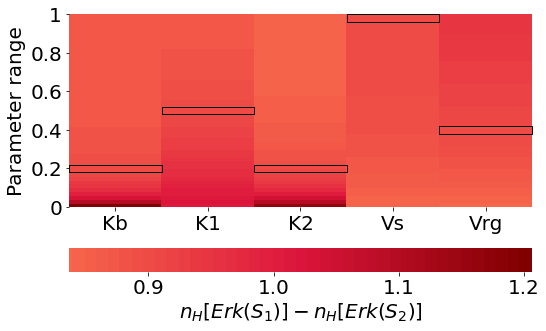

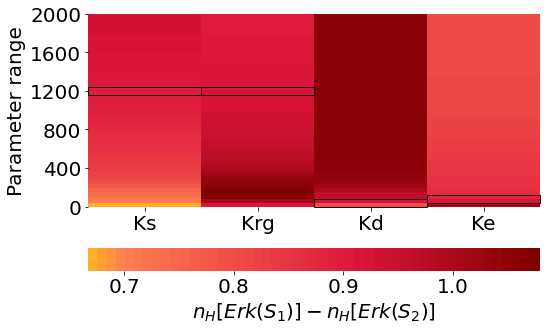

In [46]:
# Create the heatmap
data_01= np.stack((diff_Kb_fit, diff_K1_fit, diff_K2_fit, diff_Vs_fit, diff_Vrg_fit) , axis=-1)
data_02000= np.stack((diff_Ks_fit, diff_Krg_fit, diff_Kd_fit, diff_Ke_fit) , axis=-1)

# Figure Parameters from 0 to 1
Min= min_array(data_01)
Max= max_array(data_01)

fig = plt.figure(figsize=(8,5))
axs = fig.gca()
myHeatmap(data_01,Min,Max, axs, label='$n_H[Erk(S_1)]-n_H[Erk(S_2)]$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Figure Parameters from 0 to 2000
Min= min_array(data_02000)
Max= max_array(data_02000)

fig = plt.figure(figsize=(8,5))
axs = fig.gca()
myHeatmap(data_02000,Min,Max, axs,label='$n_H[Erk(S_1)]-n_H[Erk(S_2)]$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()